## Define the Hamiltonian

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def QWZ_model(k_vec, dim=3):

    Hk = np.zeros((dim,dim), dtype=complex)
    t = 1                       # hopping amplitude
    q = 3
    phi = 1./q                  # flux per plaquette

    kx = k_vec[0]
    ky = k_vec[1]
    # diagonal elements
    for i in range(3):
        Hk[i,i] = -2*t*np.cos( ky - 2.*(i+1)*np.pi*phi )

    # off-diagonal elements
    Hk[0,1] = -t
    Hk[1,2] = -t
    Hk[0,2] = -t*np.exp(-q*1.j*kx)

    # Make it hermitian
    Hk = Hk + Hk.conj().T

    return Hk

## Plot the dispersion relation

In [23]:
def get_eigen(kx, ky):
    hk = QWZ_model(np.array([kx, ky]))
    E,states=np.linalg.eigh(hk)
    return E[0],E[1],states

## Calculate the lattice field

In [100]:
def Lat_Field(mom,delta_mom):
    
    mom=mom
    momx=np.array([mom[0]+delta_mom[0],mom[1]])
    momy=np.array([mom[0],mom[1]+delta_mom[1]])
    momxy=np.array([mom[0]+delta_mom[0],mom[1]+delta_mom[1]])
    
    El,Eu,psi=get_eigen(mom[0], mom[1])
    Elx,Eux,psix=get_eigen(momx[0], momx[1])
    Ely,Eux,psiy=get_eigen(momy[0], momy[1])
    Elxy,Euxy,psixy=get_eigen(momxy[0], momxy[1])
    
    U1x=(np.conj(psi[:,1])@psix[:,1])/(np.absolute(np.conj(psi[:,1])@psix[:,1]))
    U1y=(np.conj(psi[:,1])@psiy[:,1])/(np.absolute(np.conj(psi[:,1])@psiy[:,1]))
    U2x=(np.conj(psix[:,1])@psixy[:,1])/(np.absolute(np.conj(psix[:,1])@psixy[:,1]))
    U2y=(np.conj(psiy[:,1])@psixy[:,1])/(np.absolute(np.conj(psiy[:,1])@psixy[:,1]))

    LField=np.log(U1x*U2x/(U2y*U1y))

    return LField

## Calculating the Berry curvature and Chern number

In [117]:
from mpl_toolkits.mplot3d import Axes3D

def berry_curv_plot(kxmax,kymax,A):  
    xmom=np.linspace(0,kxmax,200)
    ymom=np.linspace(0,kymax,200)
    
    delta_mom=np.array([kxmax/200,kymax/200])
    Berry_curv=[]
    chern=0
    for kx in xmom:
        for ky in ymom:
            mom=np.array([kx,ky])
            LField = Lat_Field(mom, delta_mom)
            Berry_curv.extend([LField])
            chern+=LField/(2j*np.pi)
      
    Berry_curvature=np.transpose(np.reshape(Berry_curv,(len(xmom),len(ymom))))
    

    #plt.contourf(xmom, ymom, np.imag(Berry_curvature)/(2*np.pi), 15, cmap='RdBu')
    #plt.xlim(0,A[0])
    #plt.ylim(0,A[1])
    #plt.colorbar();
    
    fig = pl.figure()
    ax = fig.gca(projection='3d')

    kx = np.linspace(0,2.*np.pi/3., 200)
    ky = np.linspace(0,2.*np.pi, 200)

    kx, ky = np.meshgrid(kx,ky)

    surf = ax.plot_surface(kx, ky, np.imag(Berry_curvature),linewidth=0, cmap="coolwarm")
    # ax.set_xlim(0,2.*np.pi/3.)
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 1.5, 1, 1]))
    plt.show()

    print("The chern number is: "+str(np.real(chern)))

Chern number associated with each band:  [-1.  2. -1.]


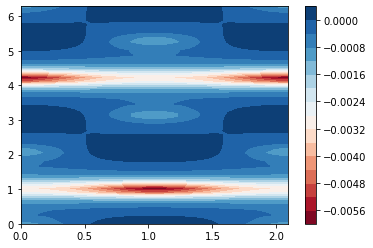

In [103]:
import numpy as np
import numpy.linalg as lg

%matplotlib notebook
########################################
###            Functions             ###
########################################
def H_k(k_vec, dim=3):
    """function to construct the Hamiltonian of a 2DEG in
    presence of an applied magnetic field. The magnetic
    field is introduced using Landau's guage.  
    input:
    ------
    k_vec: vec(2), float, (kx, ky)
    dim: integer, dimension of Hamiltonian, depends on magnetic flux
    return:
    -------
    Hk: (2,2) complex, k-representation of H
    """
    Hk = np.zeros((dim,dim), dtype=complex)
    t = 1                       # hopping amplitude
    q = 3
    phi = 1./q                  # flux per plaquette

    kx = k_vec[0]
    ky = k_vec[1]
    # diagonal elements
    for i in range(3):
        Hk[i,i] = -2*t*np.cos( ky - 2.*(i+1)*np.pi*phi )

    # off-diagonal elements
    Hk[0,1] = -t
    Hk[1,2] = -t
    Hk[0,2] = -t*np.exp(-q*1.j*kx)

    # Make it hermitian
    Hk = Hk + Hk.conj().T

    return Hk
############################################################

def build_U(vec1,vec2):
    """function to calculate the iner product of two
    eigenvectors divided by the norm:
    
    U = <psi|psi+mu>/|<psi|psi+mu>|
    input:
    ------
    vec, vec2: vectors complex.
    return:
    -------
    U: scalar complex number
    """

    # U = <psi|psi+mu>/|<psi|psi+mu>|
    in_product = np.dot(vec1,vec2.conj())

    U = in_product / np.abs(in_product)

    return U
############################################################

def latF(k_vec, Dk, dim):
    """calulate lattice field using the definition: F12 = ln[
    U1 * U2(k+1) * U1(k_2)^-1 * U2(k)^-1 ] for each
    k=(kx,ky) point, four U must be calculated.  The lattice
    field has the same dimension of the number of energy
    bands.
    
    input:
    ------
    k_vec:vec(2), float, (kx,ky).
    Dk: vec(2), float, (Dkx,Dky),
    dim:integer,  dim of H(k)
    
    return:
    -------
    F12:vec(dim), complex, lattice field corresponding to each band.
    E_sort: vec(dim) float, eigenenergies.
    """

    # Here we calculate the band structure and sort
    # them from low to high eigenenergies

    k = k_vec
    E, aux = lg.eig( H_k(k) )
    idx = E.argsort()
    E_sort = E[idx]
    psi = aux[:,idx]

    k = np.array([k_vec[0]+Dk[0], k_vec[1]], float)
    E, aux = lg.eig( H_k(k) )
    idx = E.argsort()
    psiDx = aux[:,idx]

    k = np.array([k_vec[0], k_vec[1]+Dk[1]], float)
    E, aux = lg.eig( H_k(k) )
    idx = E.argsort()
    psiDy = aux[:,idx]

    k = np.array([k_vec[0]+Dk[0], k_vec[1]+Dk[1]], float)
    E, aux = lg.eig( H_k(k) )
    idx = E.argsort()
    psiDxDy = aux[:,idx]

    U1x = np.zeros((dim), dtype=complex)
    U2y = np.zeros((dim), dtype=complex)
    U1y = np.zeros((dim), dtype=complex)
    U2x = np.zeros((dim), dtype=complex)

    for i in range(dim):
        U1x[i] = build_U(psi[:,i], psiDx[:,i] )
        U2y[i] = build_U(psi[:,i], psiDy[:,i] )
        U1y[i] = build_U(psiDy[:,i], psiDxDy[:,i] )
        U2x[i] = build_U(psiDx[:,i], psiDxDy[:,i] )

    F12 = np.zeros((dim), dtype=complex)

    F12 = np.log( U1x * U2x * 1./U1y * 1./U2y)

    return F12, E_sort

##################################################
###             Main program                   ###
##################################################
%matplotlib inline
x_res = 50
y_res = 50
q = 3
Nd = q                          # dimension of the Hamiltonian

Dx = (2.*np.pi/3.)/x_res
Dy = (2.*np.pi)/y_res
Dk = np.array([Dx,Dy], float)

LF = np.zeros((Nd), dtype=complex)
LF_arr = np.zeros((Nd,x_res, y_res), dtype=float) # plotting array
sumN = np.zeros((Nd), dtype=complex)
E_k = np.zeros((Nd), dtype=complex)
chernN = np.zeros((Nd), dtype=complex)

for ix in range(x_res):

    kx = ix*Dx
    for iy in range(y_res):

        ky = iy*Dy

        k_vec = np.array([kx,ky], float)
        LF, E_k = latF(k_vec, Dk, Nd)

        sumN += LF

        # save data for plotting
        LF_arr[:,ix,iy] = -LF.imag/(2.*np.pi) 

chernN = sumN.imag/(2.*np.pi)
print("Chern number associated with each band: ", chernN)

##################################################
###             Main program                   ###
##################################################

kx = np.linspace(0,2.*np.pi/3., x_res)
ky = np.linspace(0,2.*np.pi, y_res)

kx, ky = np.meshgrid(ky,kx)

plt.contourf(ky, kx, LF_arr[1,:,:], 15, cmap='RdBu')

plt.colorbar();

In [74]:
Lat_Field(np.array([0.33,3]),np.array([2*np.pi/(3*50),2*np.pi/50]))

(1.425067288701948e-16-0.001661405166425996j)

In [96]:
Z.ndim

2

In [98]:
Berry_curvature

array([[ 8.79402576e-17+4.71502296e-04j,  3.61571234e-17+4.72371727e-04j,
        -4.07351512e-17+4.74112009e-04j, ...,
        -3.31899934e-17+4.72398035e-04j, -5.92961312e-17+4.71511090e-04j,
         8.79337460e-17+4.71502296e-04j],
       [-1.46561634e-16+7.93796042e-04j, -2.55481442e-16+7.94100543e-04j,
        -1.41763987e-16+7.94710013e-04j, ...,
         6.04707409e-17+7.94109757e-04j, -1.47755104e-16+7.93799122e-04j,
        -3.68584269e-16+7.93796042e-04j],
       [-2.27597753e-18+1.30068221e-03j,  2.65369070e-16+1.30050141e-03j,
         7.19100267e-17+1.30013823e-03j, ...,
         2.37984283e-16+1.30049593e-03j, -2.43646910e-16+1.30068038e-03j,
         2.19768522e-16+1.30068221e-03j],
       ...,
       [-5.73352642e-17+5.82404703e-05j, -2.52422750e-17+6.06282009e-05j,
         9.73804903e-17+6.54084801e-05j, ...,
        -2.60907578e-17+6.07004572e-05j,  2.09874232e-16+5.82646205e-05j,
        -5.73352634e-17+5.82404703e-05j],
       [ 3.54372744e-17+2.43710290e-04j,  3.

Chern number associated with each band:  [-1.  2. -1.]


<IPython.core.display.Javascript object>


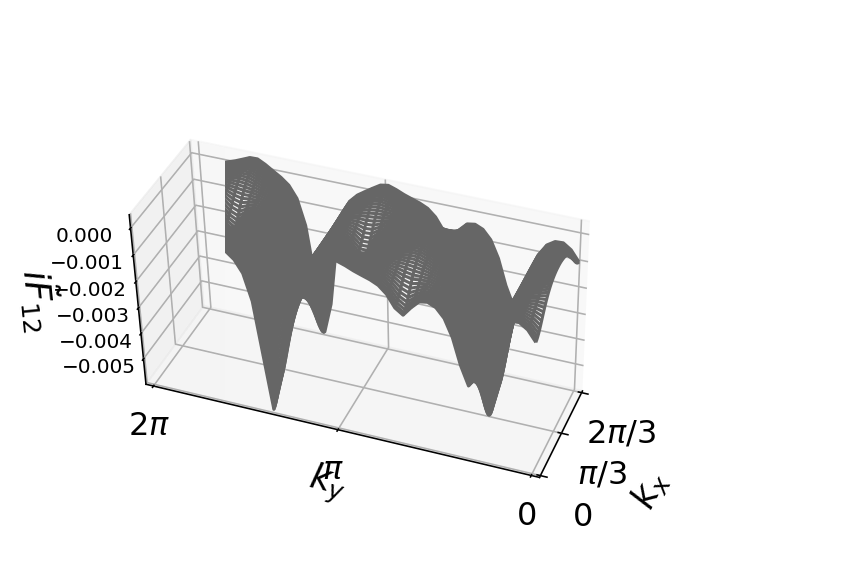

In [105]:
import numpy as np
import numpy.linalg as lg

%matplotlib notebook
########################################
###            Functions             ###
########################################
def H_k(k_vec, dim=3):
    """function to construct the Hamiltonian of a 2DEG in
    presence of an applied magnetic field. The magnetic
    field is introduced using Landau's guage.  
    input:
    ------
    k_vec: vec(2), float, (kx, ky)
    dim: integer, dimension of Hamiltonian, depends on magnetic flux
    return:
    -------
    Hk: (2,2) complex, k-representation of H
    """
    Hk = np.zeros((dim,dim), dtype=complex)
    t = 1                       # hopping amplitude
    q = 3
    phi = 1./q                  # flux per plaquette

    kx = k_vec[0]
    ky = k_vec[1]
    # diagonal elements
    for i in range(3):
        Hk[i,i] = -2*t*np.cos( ky - 2.*(i+1)*np.pi*phi )

    # off-diagonal elements
    Hk[0,1] = -t
    Hk[1,2] = -t
    Hk[0,2] = -t*np.exp(-q*1.j*kx)

    # Make it hermitian
    Hk = Hk + Hk.conj().T

    return Hk
############################################################

def build_U(vec1,vec2):
    """function to calculate the iner product of two
    eigenvectors divided by the norm:
    
    U = <psi|psi+mu>/|<psi|psi+mu>|
    input:
    ------
    vec, vec2: vectors complex.
    return:
    -------
    U: scalar complex number
    """

    # U = <psi|psi+mu>/|<psi|psi+mu>|
    in_product = np.dot(vec1,vec2.conj())

    U = in_product / np.abs(in_product)

    return U
############################################################

def latF(k_vec, Dk, dim):
    """calulate lattice field using the definition: F12 = ln[
    U1 * U2(k+1) * U1(k_2)^-1 * U2(k)^-1 ] for each
    k=(kx,ky) point, four U must be calculated.  The lattice
    field has the same dimension of the number of energy
    bands.
    
    input:
    ------
    k_vec:vec(2), float, (kx,ky).
    Dk: vec(2), float, (Dkx,Dky),
    dim:integer,  dim of H(k)
    
    return:
    -------
    F12:vec(dim), complex, lattice field corresponding to each band.
    E_sort: vec(dim) float, eigenenergies.
    """

    # Here we calculate the band structure and sort
    # them from low to high eigenenergies

    k = k_vec
    E, aux = lg.eig( H_k(k) )
    idx = E.argsort()
    E_sort = E[idx]
    psi = aux[:,idx]

    k = np.array([k_vec[0]+Dk[0], k_vec[1]], float)
    E, aux = lg.eig( H_k(k) )
    idx = E.argsort()
    psiDx = aux[:,idx]

    k = np.array([k_vec[0], k_vec[1]+Dk[1]], float)
    E, aux = lg.eig( H_k(k) )
    idx = E.argsort()
    psiDy = aux[:,idx]

    k = np.array([k_vec[0]+Dk[0], k_vec[1]+Dk[1]], float)
    E, aux = lg.eig( H_k(k) )
    idx = E.argsort()
    psiDxDy = aux[:,idx]

    U1x = np.zeros((dim), dtype=complex)
    U2y = np.zeros((dim), dtype=complex)
    U1y = np.zeros((dim), dtype=complex)
    U2x = np.zeros((dim), dtype=complex)

    for i in range(dim):
        U1x[i] = build_U(psi[:,i], psiDx[:,i] )
        U2y[i] = build_U(psi[:,i], psiDy[:,i] )
        U1y[i] = build_U(psiDy[:,i], psiDxDy[:,i] )
        U2x[i] = build_U(psiDx[:,i], psiDxDy[:,i] )

    F12 = np.zeros((dim), dtype=complex)

    F12 = np.log( U1x * U2x * 1./U1y * 1./U2y)

    return F12, E_sort

##################################################
###             Main program                   ###
##################################################

x_res = 50
y_res = 50
q = 3
Nd = q                          # dimension of the Hamiltonian

Dx = (2.*np.pi/3.)/x_res
Dy = (2.*np.pi)/y_res
Dk = np.array([Dx,Dy], float)

LF = np.zeros((Nd), dtype=complex)
LF_arr = np.zeros((Nd,x_res, y_res), dtype=float) # plotting array
sumN = np.zeros((Nd), dtype=complex)
E_k = np.zeros((Nd), dtype=complex)
chernN = np.zeros((Nd), dtype=complex)

for ix in range(x_res):

    kx = ix*Dx
    for iy in range(y_res):

        ky = iy*Dy

        k_vec = np.array([kx,ky], float)
        LF, E_k = latF(k_vec, Dk, Nd)

        sumN += LF

        # save data for plotting
        LF_arr[:,ix,iy] = -LF.imag/(2.*np.pi) 

chernN = sumN.imag/(2.*np.pi)
print("Chern number associated with each band: ", chernN)

##################################################
###             Main program                   ###
##################################################

import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = pl.figure()
ax = fig.gca(projection='3d')

kx = np.linspace(0,2.*np.pi/3., x_res)
ky = np.linspace(0,2.*np.pi, y_res)

kx, ky = np.meshgrid(ky,kx)

surf = ax.plot_wireframe(ky, kx, LF_arr[1,:,:], rstride=1, cstride=1, color='0.4')
# ax.set_xlim(0,2.*np.pi/3.)

# Set viewpoint.
ax.azim = -60
ax.elev = 30

# Label axes.
ax.set_xlabel(r'$k_x$', fontsize=18)
ax.set_xticks([0.0, np.pi/3, 2*np.pi/3])
ax.set_xticklabels([r'$0$', r'$\pi/3$', r'$2\pi/3$'], fontsize=16)
ax.set_xlim(0,2*np.pi/3)

ax.set_ylabel(r'$k_y$', fontsize=18)
ax.yaxis._axinfo['label']['space_factor'] = 2.5
ax.set_yticks([0.0, np.pi, 2*np.pi])
ax.set_yticklabels([r'$0$', r'$\pi$', r'$2\pi$'], fontsize=16)
ax.set_ylim(0,2*np.pi)


ax.set_zlabel(r'$i\tilde{F}_{12}$', fontsize=18)
ax.zaxis._axinfo['label']['space_factor'] = 2.5

# ax.set_zticks([""])

# ax.set_zticklabels([""])


# surf = ax.plot_surface(ky, kx, LF_arr[1,:,:], rstride=1, cstride=1, color='g', norm=0.1, shade=True,
#                           facecolor='b', linewidth=0, antialiased=False) #cmap=cm.jet

# To rescale the plot
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 1.5, 1, 1]))

# ax.auto_scale_xyz([0, 500], [0, 500], [0, 0.15])
# ax.pbaspect = [.6, 2.6, 0.25]
# fig.colorbar(surf, shrink=1., aspect=5)

pl.show()

<IPython.core.display.Javascript object>


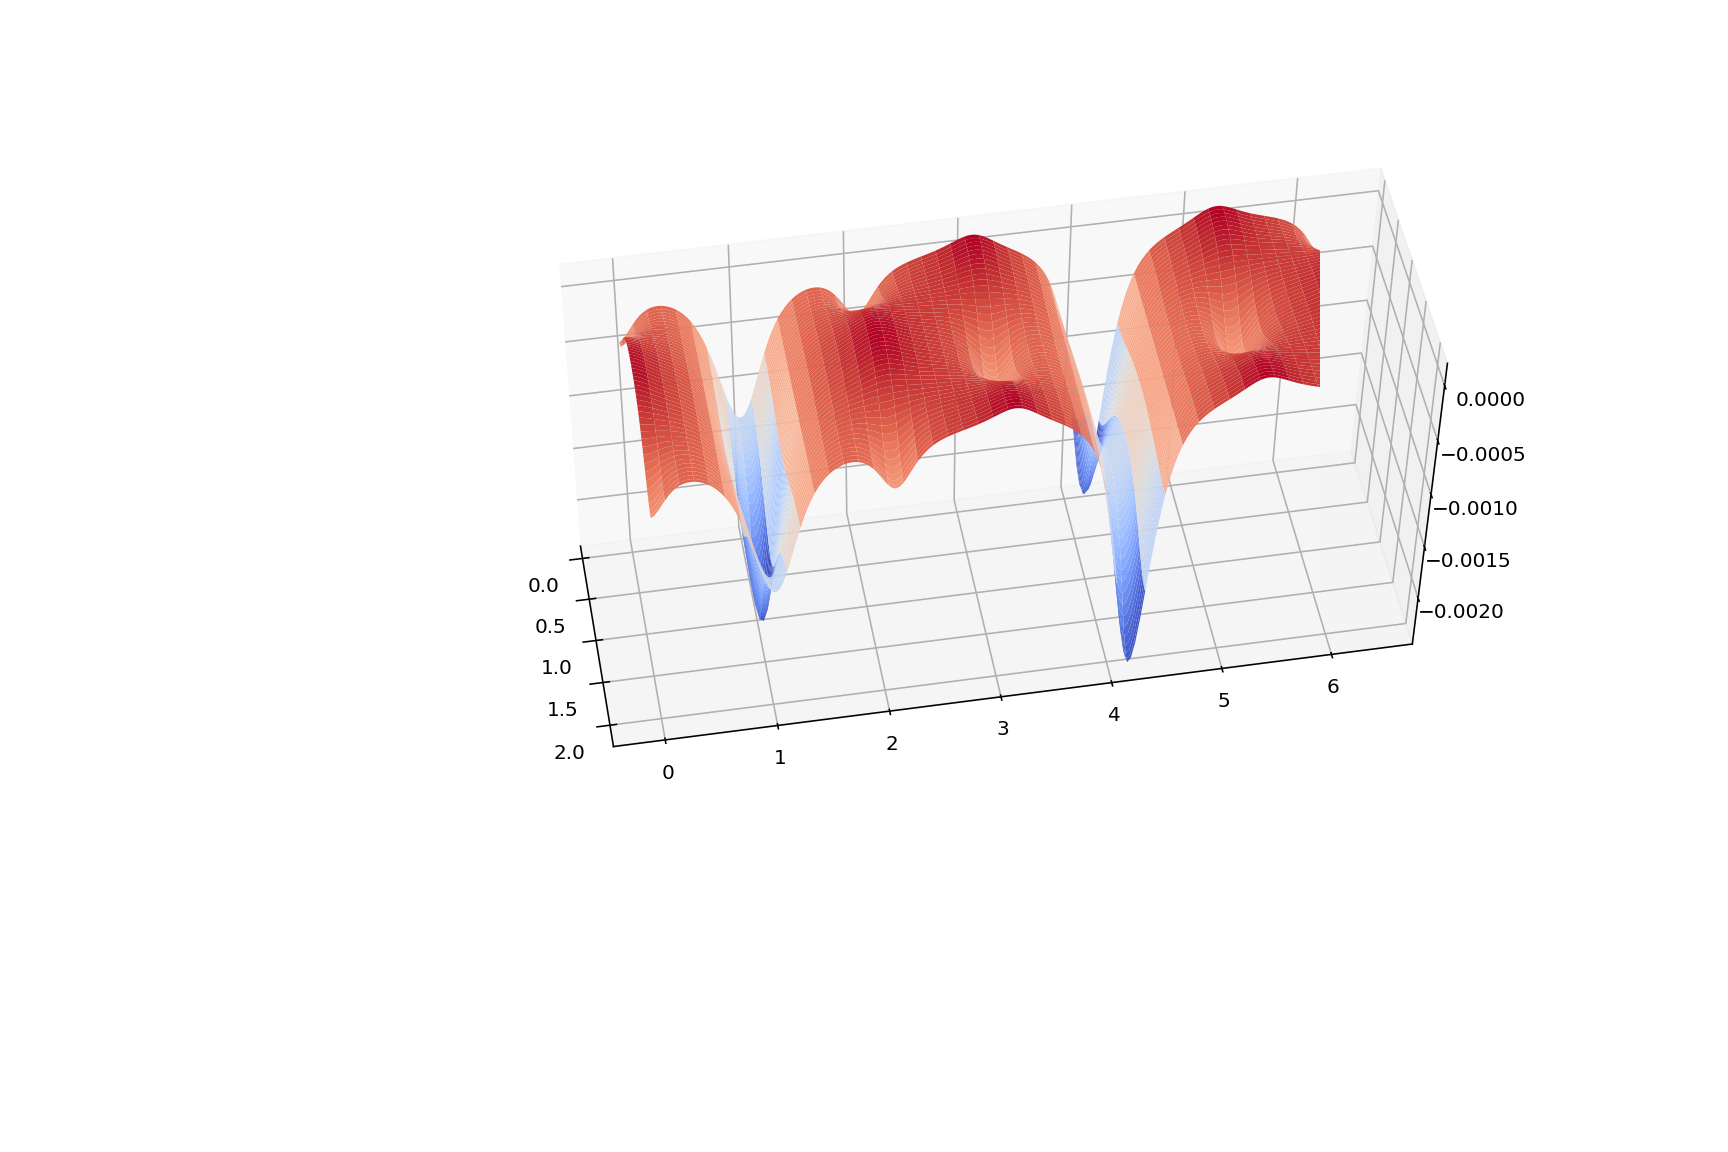

The chern number is: -1.9935136271495817


In [118]:
%matplotlib notebook

berry_curv_plot(2*np.pi/3,2*np.pi,[2*np.pi/3,2*np.pi])

In [34]:
def chern(m,kxmax,kymax):  
    xmom=np.linspace(0,kxmax,50)
    ymom=np.linspace(0,kymax,50)
    
    delta_mom=np.array([kxmax/50,kymax/50])
    Berry_curv=[]
    chern=0
    for kx in xmom:
        for ky in ymom:
            mom=np.array([kx,ky])
            LField = Lat_Field(m,mom,delta_mom)
            Berry_curv.extend([LField])
            chern+=LField/(2j*np.pi)
    return np.real(chern)

In [44]:
Chern=[]

mrange=np.linspace(0,6,100)

n=0

for m in mrange:
    n+=1
    c=chern(m,2*np.pi,2*np.pi)
    Chern.extend([round(c)])
    print(m,round(c),n/100*100)

0.0 0 1.0
0.06060606060606061 1 2.0
0.12121212121212122 1 3.0
0.18181818181818182 1 4.0
0.24242424242424243 1 5.0
0.30303030303030304 1 6.0
0.36363636363636365 1 7.000000000000001
0.42424242424242425 1 8.0
0.48484848484848486 1 9.0
0.5454545454545454 1 10.0
0.6060606060606061 1 11.0
0.6666666666666667 1 12.0
0.7272727272727273 1 13.0
0.7878787878787878 1 14.000000000000002
0.8484848484848485 1 15.0
0.9090909090909092 1 16.0
0.9696969696969697 1 17.0
1.0303030303030303 1 18.0
1.0909090909090908 1 19.0
1.1515151515151516 1 20.0
1.2121212121212122 1 21.0
1.2727272727272727 1 22.0
1.3333333333333335 1 23.0
1.393939393939394 1 24.0
1.4545454545454546 1 25.0
1.5151515151515151 1 26.0
1.5757575757575757 1 27.0
1.6363636363636365 1 28.000000000000004
1.696969696969697 1 28.999999999999996
1.7575757575757576 1 30.0
1.8181818181818183 1 31.0
1.878787878787879 1 32.0
1.9393939393939394 1 33.0
2.0 -1 34.0
2.0606060606060606 -1 35.0
2.121212121212121 -1 36.0
2.1818181818181817 -1 37.0
2.24242424242

## Phase diagram

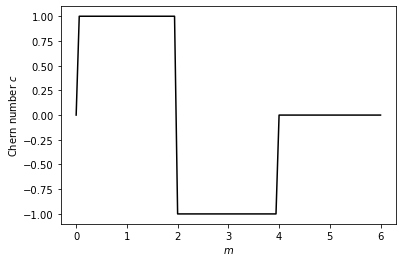

In [46]:
%matplotlib inline
plt.plot(mrange,Chern,color="k")
plt.xlabel("$m$")
plt.ylabel("Chern number $c$")
plt.show()